# Audio Transformer

## Library

In [176]:
# library
import os
import shutil
import  joblib
import numpy as np
import pandas as pd
import librosa as lb
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from IPython.display import Audio
from pathlib import Path
from tqdm.notebook import tqdm
from pydub import AudioSegment
from torchvision import datasets, transforms
import pandas as pd

In [178]:
# path
DATA_ROOT = Path("../input/rfcx-species-audio-detection")
TRAIN_AUDIO_ROOT = Path("../input/rfcx-species-audio-detection/train")
TEST_AUDIO_ROOT = Path("../input/rfcx-species-audio-detection/test")

OUT_TRAIN = Path("../input/rfcx-species-audio-detection/train_mel")
# OUT_TEST = Path("../input/rfcx-species-audio-detection/test_mel")
# OUT_TEST = Path("../input/rfcx-species-audio-detection/test_mel_time")
OUT_TEST = Path("../input/rfcx-species-audio-detection/test_mel_freq")

OUT_VALID = Path("../input/rfcx-species-audio-detection/valid_mel")

OUT_TRAIN_AUG = Path("../input/rfcx-species-audio-detection/train_mel_clip_aug")

OUTE_TEST_MIN = Path("e:/002_datasets/000_RFCX/test_mel_min")

In [179]:
# train and test
df_train = pd.DataFrame({
    "recording_id": [path.stem for path in Path(TRAIN_AUDIO_ROOT).glob("*.flac")],
})

df_test = pd.DataFrame({
    "recording_id": [path.stem for path in Path(TEST_AUDIO_ROOT).glob("*.flac")],
})

In [180]:
# 5 -
class params:
    sr = 48000
    n_mels = 320
    # n_mels = 128
    # n_mels = 640
    fmin = 40
    fmax = sr // 2
    fft = 2048
    # fft = 1024
    # fft = 4096
    hop = 256
    clip_frame = 10 * 48000
    augnum = 100

In [181]:
# Data load
df_train_tp = pd.read_csv(Path("../input/rfcx-species-audio-detection/train_tp.csv"))
df_train_tp.head()

recording_id  species_id  songtype_id    t_min     f_min    t_max     f_max
0    003bec244          14            1  44.5440  2531.250  45.1307   5531.25
1    006ab765f          23            1  39.9615  7235.160  46.0452  11283.40
2    007f87ba2          12            1  39.1360   562.500  42.2720   3281.25
3    0099c367b          17            4  51.4206  1464.260  55.1996   4565.04
4    009b760e6          10            1  50.0854   947.461  52.5293  10852.70

In [182]:
df_train_tp["t_dur"] = df_train_tp["t_max"] - df_train_tp["t_min"]
df_train_tp.head()

recording_id  species_id  songtype_id    t_min     f_min    t_max     f_max  \
0    003bec244          14            1  44.5440  2531.250  45.1307   5531.25   
1    006ab765f          23            1  39.9615  7235.160  46.0452  11283.40   
2    007f87ba2          12            1  39.1360   562.500  42.2720   3281.25   
3    0099c367b          17            4  51.4206  1464.260  55.1996   4565.04   
4    009b760e6          10            1  50.0854   947.461  52.5293  10852.70   

    t_dur  
0  0.5867  
1  6.0837  
2  3.1360  
3  3.7790  
4  2.4439

In [183]:
# how max???
df_train_tp.describe()

species_id  songtype_id        t_min         f_min        t_max  \
count  1216.000000  1216.000000  1216.000000   1216.000000  1216.000000   
mean     12.023849     1.315789    29.388748   2907.110280    31.925867   
std       7.101400     0.921055    17.488898   2528.642227    17.553856   
min       0.000000     1.000000     0.026700     93.750000     0.666700   
25%       6.000000     1.000000    14.164000    947.461000    16.158150   
50%      12.000000     1.000000    29.514650   2343.750000    31.869350   
75%      18.000000     1.000000    45.257175   3843.750000    48.046800   
max      23.000000     4.000000    59.253300  10687.500000    59.994700   

              f_max        t_dur  
count   1216.000000  1216.000000  
mean    6043.157895     2.537119  
std     3468.795425     1.903589  
min      843.750000     0.272000  
25%     3937.500000     1.093300  
50%     5062.500000     1.856000  
75%     8250.000000     3.344000  
max    13687.500000     7.923900

## Load audio

In [184]:
# load
def load_audio(record, sr=48000, root=""):
    y, _ = lb.load(
        root.joinpath(record).with_suffix(".flac").as_posix(),
        sr=sr, 
    )
    return y, _
y, sr = load_audio(df_train_tp.head(1).values[0][0], params.sr, TRAIN_AUDIO_ROOT)

## Convert Functions

In [185]:
class AudioTransform:
    def __init__(self, always_apply=False, p=0.5):
        self.always_apply = always_apply
        self.p = p

    def __call__(self, y: np.ndarray):
        if self.always_apply:
            return self.apply(y)
        else:
            if np.random.rand() < self.p:
                return self.apply(y)
            else:
                return y

    def apply(self, y: np.ndarray):
        raise NotImplementedError


class Compose:
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, y: np.ndarray):
        for trns in self.transforms:
            y = trns(y)
        return y


class OneOf:
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, y: np.ndarray):
        n_trns = len(self.transforms)
        trns_idx = np.random.choice(n_trns)
        trns = self.transforms[trns_idx]
        return trns(y)

### Normal

In [186]:
# display(Audio(y, rate=sr))
# librosa.display.waveplot(y, sr=sr);

### Noise

In [187]:
# class AddGaussianNoise(AudioTransform):
#     def __init__(self, always_apply=False, p=0.5, max_noise_amplitude=0.5, **kwargs):
#         super().__init__(always_apply, p)

#         self.noise_amplitude = (0.0, max_noise_amplitude)

#     def apply(self, y: np.ndarray, **params):
#         noise_amplitude = np.random.uniform(*self.noise_amplitude)
#         noise = np.random.randn(len(y))
#         augmented = (y + noise * noise_amplitude).astype(y.dtype)
#         return augmented

In [188]:
# transform = AddGaussianNoise(always_apply=True, max_noise_amplitude=0.05)
# y_gaussian_added = transform(y)
# display(Audio(y_gaussian_added, rate=sr))
# librosa.display.waveplot(y_gaussian_added, sr=sr);

### Gaussian Noise SNR

In [145]:
# class GaussianNoiseSNR(AudioTransform):
#     def __init__(self, always_apply=False, p=0.5, min_snr=5.0, max_snr=20.0, **kwargs):
#         super().__init__(always_apply, p)

#         self.min_snr = min_snr
#         self.max_snr = max_snr

#     def apply(self, y: np.ndarray, **params):
#         snr = np.random.uniform(self.min_snr, self.max_snr)
#         a_signal = np.sqrt(y ** 2).max()
#         a_noise = a_signal / (10 ** (snr / 20))

#         white_noise = np.random.randn(len(y))
#         a_white = np.sqrt(white_noise ** 2).max()
#         augmented = (y + white_noise * 1 / a_white * a_noise).astype(y.dtype)
#         return augmented

In [146]:
# transform = GaussianNoiseSNR(always_apply=True, min_snr=5, max_snr=20)
# y_gaussian_snr = transform(y)
# display(Audio(y_gaussian_snr, rate=sr))
# librosa.display.waveplot(y_gaussian_snr, sr=sr);


### Pink Noise

In [147]:
# import colorednoise as cn

# class PinkNoiseSNR(AudioTransform):
#     def __init__(self, always_apply=False, p=0.5, min_snr=5.0, max_snr=20.0, **kwargs):
#         super().__init__(always_apply, p)

#         self.min_snr = min_snr
#         self.max_snr = max_snr

#     def apply(self, y: np.ndarray, **params):
#         snr = np.random.uniform(self.min_snr, self.max_snr)
#         a_signal = np.sqrt(y ** 2).max()
#         a_noise = a_signal / (10 ** (snr / 20))

#         pink_noise = cn.powerlaw_psd_gaussian(1, len(y))
#         a_pink = np.sqrt(pink_noise ** 2).max()
#         augmented = (y + pink_noise * 1 / a_pink * a_noise).astype(y.dtype)
#         return augmented

In [148]:
# transform = PinkNoiseSNR(always_apply=True, min_snr=5.0, max_snr=20.0)
# y_pink_noise = transform(y)
# display(Audio(y_pink_noise, rate=sr))
# librosa.display.waveplot(y_pink_noise, sr=sr);

### Pitch shift

In [149]:
# class PitchShift(AudioTransform):
#     def __init__(self, always_apply=False, p=0.5, max_steps=5, sr=32000):
#         super().__init__(always_apply, p)

#         self.max_steps = max_steps
#         self.sr = sr

#     def apply(self, y: np.ndarray, **params):
#         n_steps = np.random.randint(-self.max_steps, self.max_steps)
#         augmented = librosa.effects.pitch_shift(y, sr=self.sr, n_steps=n_steps)
#         return augmented

In [150]:
# transform = PitchShift(always_apply=True, max_steps=2, sr=sr)
# y_pitch_shift = transform(y)
# display(Audio(y_pitch_shift, rate=sr))
# librosa.display.waveplot(y_pitch_shift, sr=sr);

### Volume Control

In [151]:
# class VolumeControl(AudioTransform):
#     def __init__(self, always_apply=False, p=0.5, db_limit=10, mode="uniform"):
#         super().__init__(always_apply, p)

#         assert mode in ["uniform", "fade", "fade", "cosine", "sine"], \
#             "`mode` must be one of 'uniform', 'fade', 'cosine', 'sine'"

#         self.db_limit= db_limit
#         self.mode = mode

#     def apply(self, y: np.ndarray, **params):
#         db = np.random.uniform(-self.db_limit, self.db_limit)
#         if self.mode == "uniform":
#             db_translated = 10 ** (db / 20)
#         elif self.mode == "fade":
#             lin = np.arange(len(y))[::-1] / (len(y) - 1)
#             db_translated = 10 ** (db * lin / 20)
#         elif self.mode == "cosine":
#             cosine = np.cos(np.arange(len(y)) / len(y) * np.pi * 2)
#             db_translated = 10 ** (db * cosine / 20)
#         else:
#             sine = np.sin(np.arange(len(y)) / len(y) * np.pi * 2)
#             db_translated = 10 ** (db * sine / 20)
#         augmented = y * db_translated
#         return augmented

In [152]:
# transform = VolumeControl(always_apply=True, mode="sine")
# y_volume_controlled = transform(y)
# Audio(y_volume_controlled, rate=sr)

### Random Crop

In [153]:
# def rc(y, sr=48000, ct=20, cdt=10, cf=10*48000):
#     clip_end = int((ct * sr) + ((cdt * sr) / 2))
#     cut_start = int(clip_end - cf)
#     offset = int(cf - (cdt * sr))
#     offset = int(random.uniform(0, offset))
#     s = cut_start + offset
#     e = s + cf
    
#     if s < 0.0:
#         e = e + -s
#         s = s + -s
#     if e > 60 * sr:
#         s = s - (e - 60 * sr)
#         e = e - (e - 60 * sr)

#     crop = y[s:e]
#     return crop, s, e

In [154]:
# ?

In [155]:
# display(Audio(y, rate=sr))

# fig = plt.figure()
# ax = fig.add_subplot(title='ax2', ylim=(-0.3, 0.3), ylabel='f')
# librosa.display.waveplot(y, sr=sr, ax=ax);

In [156]:
# fig = plt.figure()
# # ax = fig.add_subplot(title='ax2', ylim=(-0.3, 0.3), ylabel='f')
# librosa.display.waveplot(y[22 * params.sr:30 * params.sr], sr=sr, ax=ax);

In [157]:
# y_composed = transform(y)
# y_composed = rc(y_composed, sr=params.sr, ct=26, cdt=8, cf=params.clip_frame)
# display(Audio(y_composed, rate=sr))

# fig = plt.figure()
# ax = fig.add_subplot(title='ax2', ylim=(-0.3, 0.3), ylabel='f')
# display(librosa.display.waveplot(y_composed, sr=sr, max_points=50000.0, ax=ax))

In [158]:
# y_composed = transform(y)
# y_composed = rc(y_composed, sr=params.sr, ct=55, cdt=2, cf=params.clip_frame)
# display(Audio(y_composed, rate=sr))

# print(y_composed.shape)

# fig = plt.figure()
# ax = fig.add_subplot(title='ax2', ylim=(-0.3, 0.3), ylabel='f')
# display(librosa.display.waveplot(y_composed, sr=sr, max_points=50000.0, ax=ax))

## Encoding


In [159]:
# # use GPU
# import torch
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print(device)

# from efficientnet_pytorch import EfficientNet
# model_efn = EfficientNet.from_pretrained('efficientnet-b7')
# model_efn.to(device); # calculate on cpu

## Convert

In [189]:
def vizmel(melspec, t_min, t_max, beginning):
    fig, ax = plt.subplots(figsize=(15, 5))
    img = librosa.display.specshow(
        melspec, 
        sr=params.sr,
        x_axis='time', 
        y_axis='linear', 
        ax=ax)
    ax.set(title=f'Mel-frequency spectrogram of {row["recording_id"]}')
    fig.colorbar(img, ax=ax, format="%+2.f dB")

    ax.add_patch(
            patches.Rectangle(xy=((t_min - beginning) / params.sr, row["f_min"]), width=(t_max-t_min) / params.sr, height=row["f_max"] - row["f_min"], ec='#00ff00', fill=False)
        )
    ax.text((t_min - beginning) / params.sr, row["f_max"], 
    f"{row['recording_id']}",
    horizontalalignment='left', verticalalignment='bottom', color='#00ff00', fontsize=16)
    plt.show()


In [190]:
def wav_to_mel(row, isVizMel=False):
    
    # load data
    t_min = float(row["t_min"])
    t_max = float(row["t_max"])
    wav, sr = load_audio(row["recording_id"], params.sr, TRAIN_AUDIO_ROOT)
    
    # randomcrop
   #  wav, beginning, ending  = rc(wav, sr=params.sr, ct=np.round((t_min + t_max) / 2), cdt=row["t_dur"], cf=params.clip_frame)
    cutStart =int(t_max * params.sr - 10 * params.sr)
    cutEnd = int(t_min * params.sr + 10 * params.sr)
    if cutStart < 0:
        beginning = 0
        ending = int((10 * params.sr) + (t_min * params.sr ))
        offsetframe = t_min * params.sr 
    elif cutEnd > 60 * params.sr:
        beginning = int((t_max * params.sr) - 10 * params.sr)
        ending = 60 * params.sr
        offsetframe = - (60 * params.sr - t_max * params.sr)
    else:
        beginning = cutStart
        ending = cutEnd
        offsetframe = (t_min * params.sr) - beginning
        
    #cut
    wav = wav[beginning : ending]
        
    
#     print(beginning)
#     print(offsetframe / params.sr)

    if isVizMel:
        # augmentation
        #  aug = transform(wav)

        # tomel
        melspec = lb.feature.melspectrogram(
            wav, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax, n_fft=params.fft, hop_length=params.hop, 
        )
        melspec = lb.power_to_db(melspec).astype(np.float32)

        display(Audio(wav, rate=params.sr))
        vizmel(melspec, t_min * params.sr, t_max * params.sr, beginning)
        return melspec, offsetframe
        

    return wav, offsetframe


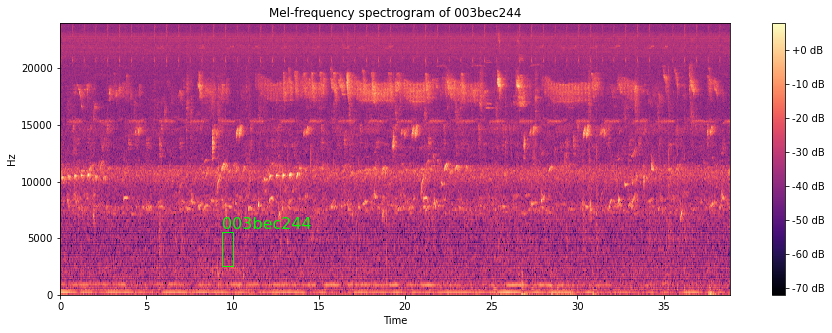

(320, 3640)


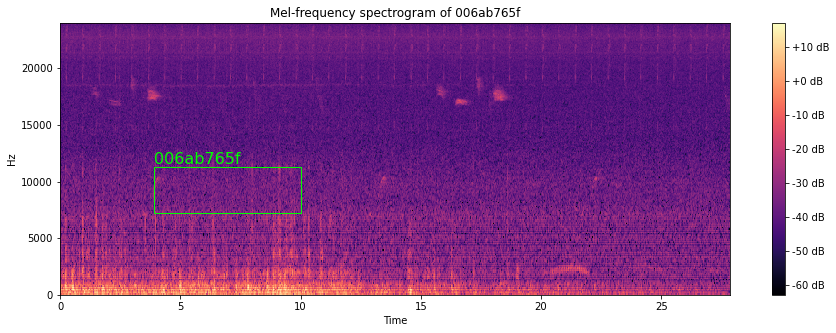

(320, 2610)



In [191]:
# test
for index, row in tqdm(df_train_tp.head(2).iterrows()):
    # wav to mel
    melspec, off = wav_to_mel(row, True)
    print(melspec.shape)

In [ ]:
ids = []
specids = []
recids = []
t_mins = []
t_maxs = []
offs = []

print(len(df_train_tp))
for index, row in tqdm(df_train_tp.iterrows()):

    # wav to mel
    wav, off = wav_to_mel(row, False)

#     # normalize
#     melspec = melspec - np.min(melspec)
#     melspec = melspec / np.max(melspec)

    # for dict
    # filename = str(index) + '_' + str(an)
    ids.append(index)
    specids.append(row["species_id"])
    recids.append(row["recording_id"])
    t_mins.append(row["t_min"])
    t_maxs.append(row["t_max"])
    offs.append(off)

    # (c seq_len d)
    np.save(os.path.join(OUT_TRAIN, str(index) + ".npy"), wav)

# save input
df_train_mel = pd.DataFrame.from_dict({'id': ids, 'species_id': specids, 'recording_id': recids, 't_min': t_mins, 't_maxs': t_maxs, 'offs':offs})
df_train_mel.to_csv(Path("../input/rfcx-species-audio-detection/train_tp_mel.csv"), index=False)
df_train_mel.head()

1216


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\tatsuya.takahashi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-163-136dd9f28331>", line 12, in <module>
    wav, off = wav_to_mel(row, False)
  File "<ipython-input-161-b1368724d9e1>", line 6, in wav_to_mel
    wav, sr = load_audio(row["recording_id"], params.sr, TRAIN_AUDIO_ROOT)
  File "<ipython-input-140-99660fe8759f>", line 3, in load_audio
    y, _ = lb.load(
  File "C:\Users\tatsuya.takahashi\anaconda3\lib\site-packages\librosa\core\audio.py", line 157, in load
    y = sf_desc.read(frames=frame_duration, dtype=dtype, always_2d=False).T
  File "C:\Users\tatsuya.takahashi\anaconda3\lib\site-packages\soundfile.py", line 867, in read
    frames = self._array_io('read', out, frames)
  File "C:\Users\tatsuya.takahashi\anaconda3\lib\site-packages\soundfile.py", line 1312, in _array_io
    return self._cdata_io(action, c

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\tatsuya.takahashi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-163-136dd9f28331>", line 12, in <module>
    wav, off = wav_to_mel(row, False)
  File "<ipython-input-161-b1368724d9e1>", line 6, in wav_to_mel
    wav, sr = load_audio(row["recording_id"], params.sr, TRAIN_AUDIO_ROOT)
  File "<ipython-input-140-99660fe8759f>", line 3, in load_audio
    y, _ = lb.load(
  File "C:\Users\tatsuya.takahashi\anaconda3\lib\site-packages\librosa\core\audio.py", line 157, in load
    y = sf_desc.read(frames=frame_duration, dtype=dtype, always_2d=False).T
  File "C:\Users\tatsuya.takahashi\anaconda3\lib\site-packages\soundfile.py", line 867, in read
    frames = self._array_io('read', out, frames)
  File "C:\Users\tatsuya.takahashi\anaconda3\lib\site-packages\soundfile.py", line 1312, in _array_io
    return self._cdata_io(action, c

In [32]:
# # save train
# ids = []
# specids = []
# recids = []

# print(len(df_train_tp))
# for index, row in tqdm(df_train_tp.iterrows()):
#     allmels = []
#     for an in range(params.augnum):
#         # wav to mel
#         melspec = wav_to_mel(row, False)

#         # normalize
#         melspec = melspec - np.min(melspec)
#         melspec = melspec / np.max(melspec)

#         # for dict
#         filename = str(index) + '_' + str(an)
#         ids.append(filename)
#         specids.append(row["species_id"])
#         recids.append(row["recording_id"])
        
#         # allmels.append(np.stack([melspec.T, melspec.T, melspec.T]).tolist())
#         batch = np.stack([np.stack([melspec.T, melspec.T, melspec.T])])
#         batch = torch.from_numpy(batch).float()
#         batch = batch.to(device)
#         batch = model_efn.extract_features(batch)
        
#         # (c seq_len d)
#         torch.save(batch[0].detach().cpu(), os.path.join(OUT_TRAIN_AUG, filename + ".pt"))

# # save input
# df_train_mel = pd.DataFrame.from_dict({'id': ids, 'species_id': specids, 'recording_id': recids})
# df_train_mel.to_csv(Path("../input/rfcx-species-audio-detection/train_tp_mel.csv"), index=False)
# df_train_mel.head()

1216


id  species_id recording_id
0  0_0          14    003bec244
1  0_1          14    003bec244
2  0_2          14    003bec244
3  0_3          14    003bec244
4  0_4          14    003bec244

## Validation

In [28]:
import math

In [ ]:
ids = []
specids = []
recids = []
t_mins = []
t_maxs = []
offs = []

print(len(df_train_tp))
for index, row in tqdm(df_train_tp.iterrows()):

    # wav to mel
    wav, off = wav_to_mel(row, False)
    center = ((row["tmin"] + row["t_max"]) / 2) * params.sr
    begin = center - 5 * (params.sr)
    

#     # normalize
#     melspec = melspec - np.min(melspec)
#     melspec = melspec / np.max(melspec)

    # for dict
    # filename = str(index) + '_' + str(an)
    ids.append(index)
    specids.append(row["species_id"])
    recids.append(row["recording_id"])
    t_mins.append(row["t_min"])
    t_maxs.append(row["t_max"])
    offs.append(off)

    # (c seq_len d)
    np.save(os.path.join(OUT_TRAIN, str(index) + ".npy"), wav)

# save input
df_train_mel = pd.DataFrame.from_dict({'id': ids, 'species_id': specids, 'recording_id': recids, 't_min': t_mins, 't_maxs': t_maxs, 'offs':offs})
df_train_mel.to_csv(Path("../input/rfcx-species-audio-detection/train_tp_mel.csv"), index=False)
df_train_mel.head()

In [41]:
# # save train
# ids = []
# specids = []
# recids = []

# print(len(df_train_tp))
# for index, row in tqdm(df_train_tp.iterrows()):
# # def wav_to_mel_validation(row, index, isVizMel=False):
    
#     # load data
#     wav, sr = load_audio(row["recording_id"], params.sr, TRAIN_AUDIO_ROOT)
    
#     # duplicate time
#     # duplicate_length = 8 * params.sr
#     duplicate_length = 5 * params.sr

#     # non duplicate length
#     hop_length = params.clip_frame - duplicate_length

#     # muptiply number
#     dev_num = math.floor(((60 * params.sr) - duplicate_length) / hop_length)

#     # Cutting!
#     for idx in range(dev_num):
        
#         # for dict
#         filename = str(index) + '_' + str(idx)
#         ids.append(filename)
#         specids.append(row["species_id"])
#         recids.append(row["recording_id"])

#         # slice
#         slice = wav[idx * hop_length: (idx * hop_length) + params.clip_frame]

#         # tomel
#         melspec = lb.feature.melspectrogram(
#             slice, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax, n_fft=params.fft, hop_length=params.hop, 
#         )
#         melspec = lb.power_to_db(melspec).astype(np.float32)

#         # normalize
#         melspec = melspec - np.min(melspec)
#         melspec = melspec / np.max(melspec)

# #         # allmels.append(np.stack([melspec.T, melspec.T, melspec.T]).tolist())
# #         batch = np.stack([np.stack([melspec.T, melspec.T, melspec.T])])
# #         batch = torch.from_numpy(batch).float()
# #         batch = batch.to(device)
# #         batch = model_efn.extract_features(batch)

#         # (c seq_len d)
#         np.save(os.path.join(OUT_VALID, filename + ".npy"), melspec)
#         # torch.save(batch[0].detach().cpu(), os.path.join(OUT_VALID, filename + ".pt"))

# # save input
# df_valid = pd.DataFrame.from_dict({'id': ids, 'species_id': specids, 'recording_id': recids})
# df_valid.to_csv(Path("../input/rfcx-species-audio-detection/valid.csv"), index=False)
# df_valid.head()

1216


id  species_id recording_id
0  0_0          14    003bec244
1  0_1          14    003bec244
2  0_2          14    003bec244
3  0_3          14    003bec244
4  0_4          14    003bec244

In [192]:
# test
import math
ids = []
specids = []
recids = []

isVizMel = True

print(len(df_test))
index = 0
for recid in tqdm(df_test.values):
    
    recid = recid[0]
    
    # load data
    wav, sr = load_audio(recid, params.sr, TEST_AUDIO_ROOT)
    
    # duplicate time
    duplicate_length = 9 * params.sr

    # non duplicate length
    hop_length = params.clip_frame - duplicate_length

    # muptiply number
    dev_num = math.floor(((60 * params.sr) - duplicate_length) / hop_length)

    # Cutting!
    for idx in range(dev_num):
        
        # for dict
        filename = str(recid) + '_' + str(idx)
        ids.append(filename)
        # specids.append(row["species_id"])
        recids.append(recid)

        # slice
        start = idx * hop_length
        end = (idx * hop_length) + params.clip_frame
        slice = wav[start: end]

        # tomel
        melspec = lb.feature.melspectrogram(
            slice, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax, n_fft=params.fft, hop_length=params.hop, 
        )
        melspec = lb.power_to_db(melspec).astype(np.float32)
        
#         if isVizMel == True:
#             fig, ax = plt.subplots(figsize=(15, 5))
#             allmel = lb.feature.melspectrogram(
#                 wav, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax, n_fft=params.fft, hop_length=params.hop, 
#             )
#             allmel = lb.power_to_db(allmel).astype(np.float32)
#             librosa.display.specshow(
#                 allmel, 
#                 sr=params.sr,
#                 x_axis='time', 
#                 y_axis='linear', )
#             plt.show()
#             isVizMel = False
#         vizmel(melspec, start, end, start)

        # normalize
        # melspec = melspec - np.min(melspec)
        # melspec = melspec / np.max(melspec)
        
        eps=1e-6
        mean = melspec.mean()
        std = melspec.std()
        spec_norm = (melspec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        spec_scaled = np.asarray(spec_scaled)

        
        # np.save(os.path.join(OUT_TEST, filename + ".npy"), spec_scaled)
        np.save(os.path.join(OUTE_TEST_MIN, filename + ".npy"), spec_scaled)
        
        # OUTE_TEST_MIN

#         # allmels.append(np.stack([melspec.T, melspec.T, melspec.T]).tolist())
#         batch = np.stack([np.stack([melspec.T, melspec.T, melspec.T])])
#         batch = torch.from_numpy(batch).float()
#         batch = batch.to(device)
#         batch = model_efn.extract_features(batch)

        # (c seq_len d)
       #  torch.save(batch[0].detach().cpu(), os.path.join(OUTE_TEST_CLIP, filename + ".pt"))

# save input
df_valid = pd.DataFrame.from_dict({'id': ids, 'recording_id': recids})
df_valid.to_csv(Path("../input/rfcx-species-audio-detection/test.csv"), index=False)
df_valid.head()

1992


id recording_id
0  000316da7_0    000316da7
1  000316da7_1    000316da7
2  000316da7_2    000316da7
3  000316da7_3    000316da7
4  000316da7_4    000316da7

In [44]:
print('done!')

done!
